# Credit Manager Take Home Challenge
### Prosper - Senior Credit Risk Analyst
#### Name: Yue Ying
#### Date: 2023-05-05

In [40]:
# Load neccessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load original data
df_original = pd.read_csv("Credit Manager_Take_Home_Data.csv")

In [20]:
df_original.head()

,SignalDateTime,isApplication,isApproval,isAcceptance,isCompletion,FICOScore,RequestedAmount,InquiryNum,BaseRatingBin,channelBin
0,3/15/20 21:15,1,1,0,0,651.0,10000.0,-4.0,5.0,1
1,3/15/20 22:57,1,1,0,0,735.0,10000.0,1.0,7.0,1
2,3/15/20 22:06,1,1,0,0,699.0,13000.0,0.0,6.0,1
3,3/16/20 4:34,1,1,0,0,731.0,40000.0,0.0,2.0,8
4,3/16/20 7:02,1,0,0,0,556.0,10000.0,1.0,8.0,8


## Exploratory Data Analysis

In [22]:
# Getting summary statistics
df_describe = df_original.describe() # include = 'all'
df_describe.loc['dtype'] = df_original.dtypes
df_describe.loc['size'] = len(df_original)
df_describe.loc['% null'] = df_original.isnull().mean()
df_describe.loc['Unique'] = df_original.nunique(axis=0)
# print(df_describe.head(10))
df_describe

,isApplication,isApproval,isAcceptance,isCompletion,FICOScore,RequestedAmount,InquiryNum,BaseRatingBin,channelBin
count,79275.0,79275.0,79275.0,79275.0,72827.0,72832.0,72825.0,69484.0,79275.0
mean,1.0,0.422592,0.024573,0.014115,686.11088,15147.093554,0.862822,5.186028,3.23971
std,0.0,0.493975,0.15482,0.117968,65.463068,9892.52559,2.390309,2.4208,3.002673
min,1.0,0.0,0.0,0.0,412.0,2000.0,-4.0,1.0,1.0
25%,1.0,0.0,0.0,0.0,644.0,8000.0,0.0,3.0,1.0
50%,1.0,0.0,0.0,0.0,688.0,11000.0,1.0,6.0,1.0
75%,1.0,1.0,0.0,0.0,731.0,20000.0,2.0,7.0,6.0
max,1.0,1.0,1.0,1.0,850.0,40000.0,65.0,8.0,8.0
dtype,int64,int64,int64,int64,float64,float64,float64,float64,int64
size,79275,79275,79275,79275,79275,79275,79275,79275,79275


In [19]:
# Checking rows with any NaN values in its data 
df_original[df_original.isna().any(axis=1)]

,SignalDateTime,isApplication,isApproval,isAcceptance,isCompletion,FICOScore,RequestedAmount,InquiryNum,BaseRatingBin,channelBin
6,3/16/20 11:43,1,0,0,0,NaN,NaN,NaN,NaN,5
14,3/16/20 10:34,1,1,1,1,791.0,5000.0,0.0,NaN,4
76,3/16/20 16:15,1,0,0,0,NaN,NaN,NaN,NaN,1
77,3/16/20 16:24,1,0,0,0,NaN,NaN,NaN,NaN,1
171,3/16/20 5:36,1,1,1,1,708.0,13000.0,0.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...
79270,3/26/20 5:43,1,0,0,0,NaN,NaN,NaN,NaN,4
79271,5/27/20 9:29,1,0,0,0,NaN,NaN,NaN,NaN,4
79272,3/27/20 9:35,1,0,0,0,NaN,NaN,NaN,NaN,4
79273,5/22/20 9:11,1,0,0,0,NaN,NaN,NaN,NaN,4


### Note:
1. Missing data: about 12% of the data contain at least 1 missing value in either of the following attributes: FICOScore, RequestedAmount, InquiryNum, BaseRatingBin

## Pre-processing data

In [82]:
df_processed = df_original.copy()

In [83]:
# Convert SignalDateTime to a datetime format
df_processed['SignalDateTime'] = pd.to_datetime(df_processed['SignalDateTime'], format='%m/%d/%y %H:%M')

In [84]:
# Get Week number from date
df_processed['week_num'] = df_processed['SignalDateTime'].dt.isocalendar().week

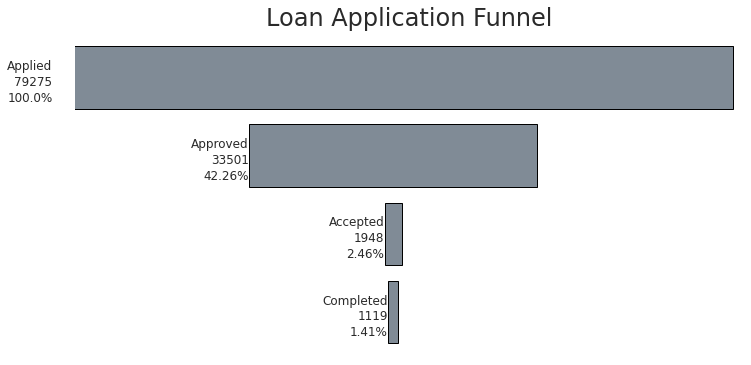

In [121]:
# Create a diagram to visualize the funnel 
# Reference 1 funnel chart
y = [4,3,2,1]
x = [df_weeklyFico.shape[0],
     df_weeklyFico[(df_weeklyFico['isApproval'] == 1)].shape[0],
     df_weeklyFico[(df_weeklyFico['isAcceptance'] == 1)].shape[0],
      df_weeklyFico[(df_weeklyFico['isCompletion'] == 1)].shape[0]]
labels = ['Applied', 'Approved', 'Accepted', 'Completed']
perc = [str(round(i/max(x)*100,2))+"%" for i in x]
x_max = 80000
x_min = 2000
x_range = max(x) - min(x)

fig, ax = plt.subplots(1, figsize=(12,6))
for idx, val in enumerate(x):
    left = (x_range - val)/2
    plt.barh(y[idx], x[idx], left = left, color='#808B96',
             height=.8, edgecolor='black')
    # label
    plt.text(left-50, y[idx]+0.1, labels[idx], ha='right', 
            fontsize=12, color='#2A2A2A')
    # value
    plt.text(left-50, y[idx]-0.1, x[idx], ha='right',
            fontsize=12, color='#2A2A2A')
    plt.text(left-50, y[idx]-0.3, perc[idx], ha='right',
            fontsize=12, color='#2A2A2A')
    
plt.xlim(x_min, x_max)
plt.axis('off')
plt.title('Loan Application Funnel',  loc='center', fontsize=24, color='#2A2A2A')
plt.show()

## Question 1
What’s the weekly trend for InquiryNum on application level?
Please use non-Excel tools to generate the summary and charts.

In [85]:
# Duplicating original table for this question
df_weeklyinquiry = df_processed.copy()

In [86]:
df_weeklyinquiry['InquiryNum_NoTradesThisType'] = np.where(df_weeklyinquiry['InquiryNum']== -1, 1, 0)
df_weeklyinquiry['InquiryNum_NotVerified'] = np.where(df_weeklyinquiry['InquiryNum']== -2, 1, 0)
df_weeklyinquiry['InquiryNum_NoOpenTrades'] = np.where(df_weeklyinquiry['InquiryNum']== -3, 1, 0)
df_weeklyinquiry['InquiryNum_NoTradesOnFile'] = np.where(df_weeklyinquiry['InquiryNum']== -4, 1, 0)
df_weeklyinquiry['InquiryNum_CannotCal'] = np.where(df_weeklyinquiry['InquiryNum']== -5, 1, 0)
df_weeklyinquiry['InquiryNum_NoOpenTradesForReqTime'] = np.where(df_weeklyinquiry['InquiryNum']== -6, 1, 0)
df_weeklyinquiry['InquiryNum_InquiryNumWithoutSpecial'] = np.where(df_weeklyinquiry['InquiryNum']>=0, df_weeklyinquiry['InquiryNum'], np.nan)

In [78]:
# df_weeklyinquiry[(df_weeklyinquiry['week_num'] == 9) & (pd.isnull(df_weeklyinquiry['InquiryNum']))]

,SignalDateTime,isApplication,isApproval,isAcceptance,isCompletion,FICOScore,RequestedAmount,InquiryNum,BaseRatingBin,channelBin,week_num,InquiryNum_NoTrades,InquiryNum_NoTradesThisType,InquiryNum_NotVerified,InquiryNum_NoOpenTrades,InquiryNum_NoTradesOnFile,InquiryNum_CannotCal,InquiryNum_NoOpenTradesForReqTime,InquiryNum_InquiryNumWithoutSpecial
1742,2020-03-01 10:27:00,1,0,0,0,NaN,NaN,NaN,NaN,1,9,0,0,0,0,0,0,0,NaN
1743,2020-03-01 10:32:00,1,0,0,0,NaN,NaN,NaN,NaN,8,9,0,0,0,0,0,0,0,NaN
1744,2020-03-01 10:34:00,1,0,0,0,NaN,NaN,NaN,NaN,8,9,0,0,0,0,0,0,0,NaN
1745,2020-03-01 10:47:00,1,0,0,0,NaN,NaN,NaN,NaN,1,9,0,0,0,0,0,0,0,NaN
1746,2020-03-01 10:59:00,1,0,0,0,NaN,NaN,NaN,NaN,1,9,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71639,2020-03-01 16:58:00,1,0,0,0,NaN,NaN,NaN,NaN,4,9,0,0,0,0,0,0,0,NaN
71675,2020-03-01 16:42:00,1,0,0,0,NaN,NaN,NaN,NaN,4,9,0,0,0,0,0,0,0,NaN
74095,2020-03-01 11:52:00,1,0,0,0,NaN,NaN,NaN,NaN,8,9,0,0,0,0,0,0,0,NaN
76524,2020-03-01 11:34:00,1,0,0,0,NaN,NaN,NaN,NaN,4,9,0,0,0,0,0,0,0,NaN


In [87]:
df_weeklyinquiry.groupby('week_num').agg(
    first_datetime_Applied = ('SignalDateTime', np.min),
    total_application=('SignalDateTime', np.size),
    total_inquiryNull = ('InquiryNum', lambda x: x.isnull().sum()),
    perc_inquiryNull =  ('InquiryNum', lambda x: x.isnull().mean()),
    total_inquiry=('InquiryNum_InquiryNumWithoutSpecial', np.sum),
    avg_inquiry=('InquiryNum_InquiryNumWithoutSpecial', np.mean),
    total_NoTradesOnFile=('InquiryNum_NoTradesOnFile', np.sum),
    perc_NoTradesOnFile=('InquiryNum_NoTradesOnFile', np.mean),
    total_NoTradesThisType=('InquiryNum_NoTradesThisType', np.sum),
    total_NotVerified=('InquiryNum_NotVerified',  np.sum),
    total_NoOpenTrades=('InquiryNum_NoOpenTrades', np.sum),
    total_CannotCal=('InquiryNum_CannotCal', np.sum),
    total_NoOpenTradesForReqTime=('InquiryNum_NoOpenTradesForReqTime', np.sum)
)

,first_datetime_Applied,total_application,total_inquiryNull,perc_inquiryNull,total_inquiry,avg_inquiry,total_NoTradesOnFile,perc_NoTradesOnFile,total_NoTradesThisType,total_NotVerified,total_NoOpenTrades,total_CannotCal,total_NoOpenTradesForReqTime
week_num,,,,,,,,,,,,,
9,2020-03-01 00:08:00,653,72,0.110260,674.0,1.316406,69,0.105666,0,0,0,0,0
10,2020-03-02 00:02:00,5953,713,0.119772,5565.0,1.189357,561,0.094238,0,0,0,0,0
11,2020-03-09 00:01:00,6908,726,0.105096,6871.0,1.252233,695,0.100608,0,0,0,0,0
12,2020-03-16 00:04:00,7167,765,0.106739,6909.0,1.213169,707,0.098647,0,0,0,0,0
13,2020-03-23 00:20:00,9372,765,0.081626,12337.0,1.585529,826,0.088135,0,0,0,0,0
14,2020-03-30 00:00:00,8147,482,0.059163,10044.0,1.462647,798,0.097950,0,0,0,0,0
15,2020-04-06 00:10:00,7182,396,0.055138,9225.0,1.503667,651,0.090643,0,0,0,0,0
16,2020-04-13 00:02:00,5592,364,0.065093,7090.0,1.500529,503,0.089950,0,0,0,0,0
17,2020-04-20 00:09:00,4817,351,0.072867,5874.0,1.443953,398,0.082624,0,0,0,0,0


### Note:
1. Given that week 9 only has 1 day of data. Some of the aggregate statistics might be skewed from the rest of the weeks. 
2. Average numbers of inquiries are relativeily consistent across week 9 to 22, ranges between 1.2 to 1.6 inquiries per application. 
3. Percentage of applications with missing inquiry data was the lowest in week 14,15, and 16 at around 6%. The rest of the weeks ranges from 7-11%.  
4. The number of applications with no trades on file are around 9-10% of the total applications per week. This seems to be the only special condition occured during this timeframe. 

## Question 2
What’s the weekly trend for average FICO score on application/approval/Acceptance/issuance level? Do you have any findings or concerns for the trend?
Please use non-Excel tools to generate the summary and charts.

In [88]:
df_weeklyFico = df_processed.copy()

In [143]:
df_weeklyFico['FICO_approved'] = np.where((df_weeklyFico['isApproval']==1) & (df_weeklyFico['FICOScore'].notnull()), df_weeklyFico['FICOScore'], np.nan)
df_weeklyFico['FICO_approvedNull'] = np.where((df_weeklyFico['isApproval']==1) & (df_weeklyFico['FICOScore'].isnull()), 1, 0)
df_weeklyFico['FICO_accepted'] = np.where((df_weeklyFico['isAcceptance']==1) & (df_weeklyFico['FICOScore'].notnull()), df_weeklyFico['FICOScore'], np.nan)
df_weeklyFico['FICO_acceptedNull'] = np.where((df_weeklyFico['isAcceptance']==1) & (df_weeklyFico['FICOScore'].isnull()), 1, 0)
df_weeklyFico['FICO_completed'] = np.where((df_weeklyFico['isCompletion']==1) & (df_weeklyFico['FICOScore'].notnull()), df_weeklyFico['FICOScore'], np.nan)
df_weeklyFico['FICO_completedNull'] = np.where((df_weeklyFico['isCompletion']==1) & (df_weeklyFico['FICOScore'].isnull()), 1, 0)

df_weeklyFico_summary = df_weeklyFico.groupby('week_num').agg(
    first_datetime_Applied = ('SignalDateTime', np.min),
    total_application=('SignalDateTime', np.size),
    avg_fico = ('FICOScore',np.mean),
    perc_ficoNull = ('FICOScore', lambda x: x.isnull().mean()),
    total_approved = ('isApproval', np.sum),
    count_approvedNullFICO = ('FICO_approvedNull', np.sum),
    avg_ficoApproved = ('FICO_approved', np.mean),
    total_accepted = ('isAcceptance', np.sum),
    count_acceptedNullFICO = ('FICO_acceptedNull', np.sum),
    avg_ficoAccepted = ('FICO_accepted', np.mean),
    total_completed = ('isCompletion', np.sum),
    count_completedNullFICO = ('FICO_completedNull', np.sum),
    avg_ficoCompleted = ('FICO_completed', np.mean)
)
df_weeklyFico_summary

,first_datetime_Applied,total_application,avg_fico,perc_ficoNull,total_approved,count_approvedNullFICO,avg_ficoApproved,total_accepted,count_acceptedNullFICO,avg_ficoAccepted,total_completed,count_completedNullFICO,avg_ficoCompleted
week_num,,,,,,,,,,,,,
9,2020-03-01 00:08:00,653,682.846242,0.110260,335,0,725.640796,20,0,714.333333,14,0,705.690476
10,2020-03-02 00:02:00,5953,681.261444,0.119772,3073,3,720.852922,178,1,719.415254,120,0,716.966667
11,2020-03-09 00:01:00,6908,684.255927,0.105096,3681,7,722.088090,196,2,722.201829,140,1,721.696643
12,2020-03-16 00:04:00,7167,691.281994,0.106739,4057,10,724.262663,215,2,721.329890,143,2,720.725296
13,2020-03-23 00:20:00,9372,681.797758,0.081626,3229,8,721.328459,162,2,723.685417,96,0,722.416667
14,2020-03-30 00:00:00,8147,683.535697,0.059163,2758,5,721.315880,174,1,711.828709,95,0,713.178947
15,2020-04-06 00:10:00,7182,684.426549,0.055138,2379,6,722.925928,135,2,721.892052,82,1,720.632716
16,2020-04-13 00:02:00,5592,687.697239,0.065093,2286,8,726.835675,133,1,717.848485,76,0,725.210526
17,2020-04-20 00:09:00,4817,689.081001,0.072659,2129,6,725.061941,144,1,716.051282,60,0,735.183333


<AxesSubplot:xlabel='week_num'>

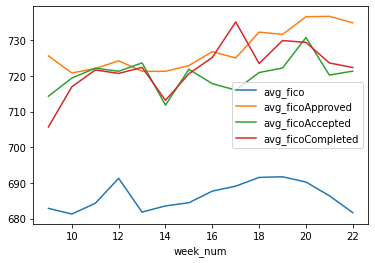

In [147]:
df_weeklyFico_summary[['avg_fico','avg_ficoApproved','avg_ficoAccepted','avg_ficoCompleted']].plot(legend=True)

### Note:
1. Overall, we generally approve applicants with much higher FICO scores from the overall population.
2. Except Week 13 & 17, the average FICO scores from completed applications are lower than the average FICO scores from approved applications. Indicating that some of the approved customers with higher FICO scores did not complete the loan process. This might be a churn problem since we are losing customers with potentially lower risks. 

## Question 3
What’s the week-over-week approval rate change? Can you think about the reasons to the trend you’ve observed?
Please use non-Excel tools to generate the summary and charts.



In [151]:
df_weeklyApproval = df_processed.copy()

In [162]:
df_weeklyApproval_summary = df_weeklyApproval.groupby('week_num').agg(
    first_datetime_Applied = ('SignalDateTime', np.min),
    total_application=('SignalDateTime', np.size),
    total_approved = ('isApproval', np.sum)
)
df_weeklyApproval_summary['wowChange_total_application'] = df_weeklyApproval_summary['total_application'].pct_change()
df_weeklyApproval_summary['prec_approved'] = df_weeklyApproval_summary['total_approved']/df_weeklyApproval_summary['total_application']
df_weeklyApproval_summary['wowChange_prec_approved'] = df_weeklyApproval_summary['prec_approved'].pct_change()
df_weeklyApproval_summary

,first_datetime_Applied,total_application,total_approved,wowChange_total_application,prec_approved,wowChange_prec_approved
week_num,,,,,,
9,2020-03-01 00:08:00,653,335,NaN,0.513017,NaN
10,2020-03-02 00:02:00,5953,3073,8.116386,0.516210,0.006225
11,2020-03-09 00:01:00,6908,3681,0.160423,0.532860,0.032255
12,2020-03-16 00:04:00,7167,4057,0.037493,0.566067,0.062317
13,2020-03-23 00:20:00,9372,3229,0.307660,0.344537,-0.391349
14,2020-03-30 00:00:00,8147,2758,-0.130708,0.338530,-0.017436
15,2020-04-06 00:10:00,7182,2379,-0.118449,0.331245,-0.021519
16,2020-04-13 00:02:00,5592,2286,-0.221387,0.408798,0.234127
17,2020-04-20 00:09:00,4817,2129,-0.138591,0.441976,0.081160


### Note:
1. Overall, our approval rate is decreasing starting from week 13. 
2. This could be partially explained by the decreasing amount total applications starting from week 13. But week 16 & 16 demonstrated different behavior. With less applications received by us, it might be harder for us to identify qualified appliants on a weekly cohort basis. 

## Question 4 (use R or Python)
Based on the dataset, could you come up with a way to predict whether an application will be approved? It could be a machine learning model, segmentation ruleset, strategy tree, etc. What’s the metrics you want to examine, and how do you evaluate the effectiveness of your proposal? If that doesn’t work well, what might be the problem? We would like to see a write-up as well as some codes if applicable.

In [166]:
df_model = df_original.copy()

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.tree  import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics 
from sklearn.preprocessing import OneHotEncoder

In [185]:
# Data preparation 
y = df_model.isApproval
X = df_model.drop(['SignalDateTime','isApplication','isApproval','isAcceptance','isCompletion'], axis=1)

# Split InquiryNum columns, create training and validation sets
X['InquiryNum_NoTradesThisType'] = np.where(X['InquiryNum']== -1, 1, 0)
X['InquiryNum_NotVerified'] = np.where(X['InquiryNum']== -2, 1, 0)
X['InquiryNum_NoOpenTrades'] = np.where(X['InquiryNum']== -3, 1, 0)
X['InquiryNum_NoTradesOnFile'] = np.where(X['InquiryNum']== -4, 1, 0)
X['InquiryNum_CannotCal'] = np.where(X['InquiryNum']== -5, 1, 0)
X['InquiryNum_NoOpenTradesForReqTime'] = np.where(X['InquiryNum']== -6, 1, 0)
X['InquiryNum_InquiryNumWithoutSpecial'] = np.where(X['InquiryNum']>=0, X['InquiryNum'], np.nan)
X = X.drop(['InquiryNum'], axis=1)
X['channelBin'] = X['channelBin'].astype(object)
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)
categorical_cols = ['channelBin']
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int32','int64', 'float64']]
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [187]:
# Handle missing data
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]
for col in cols_with_missing:
    X_train[col + '_was_missing'] = X_train[col].isnull()
    X_valid[col + '_was_missing'] = X_valid[col].isnull()
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

In [190]:
# OHE categorical column
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(imputed_X_train[categorical_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(imputed_X_valid[categorical_cols]))
OH_cols_train.index = imputed_X_train.index
OH_cols_valid.index = imputed_X_valid.index
num_imputed_X_train = imputed_X_train.drop(categorical_cols, axis=1)
num_imputed_X_valid = imputed_X_valid.drop(categorical_cols, axis=1)
OH_X_train = pd.concat([num_imputed_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_imputed_X_valid, OH_cols_valid], axis=1)
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

In [199]:
# scoring model
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return metrics.accuracy_score(y_valid, preds)

In [200]:
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

0.8425102491327657


### Note:
1. Started with a simple decision tree given the size of the data and number of features. It's also the fastest way to build a model. 
2. I performed some data transformation steps including processing missing values and changing categorical features to one-hot encoding. 
3. To evaluate model performance, I retained 20% of the data as the validation set to measure the prediction performance. Overall, it is 84% accurate. 
4. To improve model performance, we can add more features to the dataset as well as tune the model based on the desired preferences. 

## References

1. Funnel Chart: https://towardsdatascience.com/funnel-charts-with-python-1ef1a2b183ab